<b>실습 목표</b>
* 의도적으로 RNN을 하나의 주기 함수에 완전하게 fitting을 시킨다.
* sine 함수 그 자체를 만들어 보겠다.
    * x를 넣으면 y가 툭 나오는 구조는 아니고, 주기성을 학습하도록 만든다.
    * 학습된 모델을 쓸 때는 5개의 원소를 갖는 sequence가 들어와야 한다.

In [1]:
import torch # PyTorch 기본 라이브러리
import torch.nn as nn # Neural Network (NN): 뉴럴 네트워크 그 자체
import torch.optim as optim # 최적화(optimizer)를 위한 모듈(SGD, Adam)

import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda")

[0.        0.1010101 0.2020202 0.3030303 0.4040404]
[0.         0.10083842 0.20064886 0.2984138  0.39313661]
(100,)
(100,)


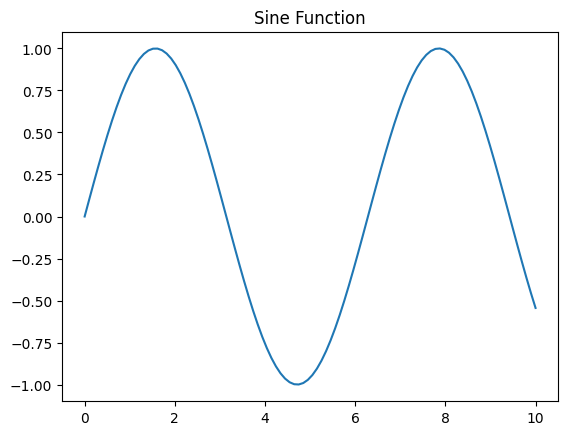

In [5]:
data_size = 100

# 약 3파이(pi) 정도까지만 x에 대하여 y를 출력해 본 겁니다.
# 나머지 모든 정의역(domain)에 대해서 y를 예측해 볼 수 있을까요?
data_x = np.linspace(0, 10, data_size) # 0부터 10까지 100개의 포인트 설정
data_y = np.sin(data_x) # 각 포인트에 대한 sine() 값 계산

print(data_x[:5])
print(data_y[:5])

print(data_x.shape)
print(data_y.shape)

# 학습 데이터가 고작 100개만 존재하는 상황인 거죠
# 이때, 우리는 학습 데이터가 주기성 혹은 시계열성을 띈다는 것을 안다면
# RNN이나 LSTM을 사용하는 것이 효과적일 것입니다.

plt.title("Sine Function")
plt.plot(data_x, data_y)
plt.show()

In [12]:
sequence_size = 5 # seq_len을 5로 고정 -> 다음 데이터 1개만 예측
train_size = data_size - sequence_size # 학습 데이터 총 95개

train_X = []
train_Y = []

for i in range(0, train_size):
    train_X.append(data_y[i:i + sequence_size]) # 앞의 5개가 주어졌을 때
    train_Y.append(data_y[i + sequence_size]) # 다음 값을 맞추는 문제

# 학습 데이터 95개는 아래와 같이 구성된다.
# (x1, x2, x3, x4, x5), (x6)
# (x2, x3, x4, x5, x6), (x7)
# (x3, x4, x5, x6, x7), (x8)
# (x4, x5, x6, x7, x8), (x9)
# ...
# (x95, x96, x97, x98, x99), (x100)
# 여기까지만 봤을 때, [95, 5, 1] → [95, 1]

train_X = np.array(train_X)
train_Y = np.array(train_Y)

# [시퀀스의 개수, 시퀀스 크기]
print(train_X.shape)
print(train_Y.shape)

train_X = torch.from_numpy(train_X)
train_Y = torch.from_numpy(train_Y)

# PyTorch에서 사용할 수 있는 형태로 변환 후에 GPU로 옮기기
train_X = torch.transpose(train_X, 0, 1).unsqueeze(2).float().to(device)
train_Y = train_Y.unsqueeze(1).float().to(device)

# RNN의 경우, 시퀀스 길이가 첫 번째 차원이 될 수 있도록 하기
print(train_X.shape) # [시퀀스 길이, 시퀀스 개수, 1]
print(train_Y.shape)

(95, 5)
(95,)
torch.Size([5, 95, 1])
torch.Size([95, 1])


In [13]:
input_dim = 1
output_dim = 1
hidden_dim = 1000

In [14]:
class RNN1(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(RNN1, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.w_xh = nn.Linear(self.input_dim, self.hidden_dim)
        self.w_hh = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.w_hy = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x, h):
        # x는 현재 토큰(token)
        # h는 이전까지 들어왔던 토큰들을 처리한 임베딩
        h = nn.Tanh()(self.w_xh(x) + self.w_hh(h)) # h가 갱신(현재의 토큰을 반영하도록)
        y = self.w_hy(h)
        return y, h

In [15]:
# 현재 모델의 출력을 확인
def show(rnn):
    rnn.eval()
    predictions = []

    # 현재 예제에서는 [학습 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(train_size, hidden_dim).to(device)

    # 시퀀스에 포함된 데이터를 연속적으로 넣기
    for x in train_X:
        y_pred, h = rnn(x, h)

    plt.title("Prediction Result")
    plt.plot(data_x[sequence_size:], data_y[sequence_size:])
    plt.plot(data_x[sequence_size:], y_pred.view(-1).cpu().detach().numpy())
    plt.legend(["Real", "Predicted"])
    plt.show()

[ Training Start ]


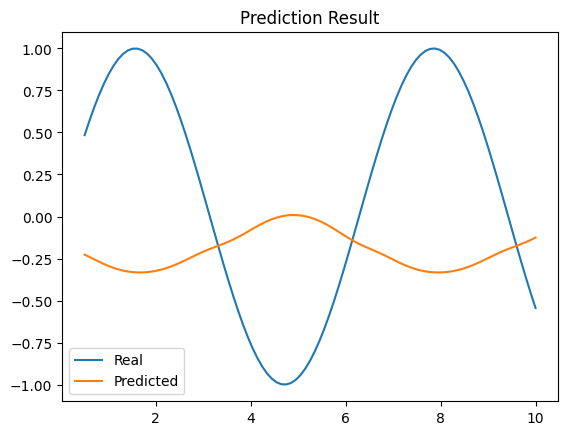

[1000/10000] loss = 1.2515673006419092e-05


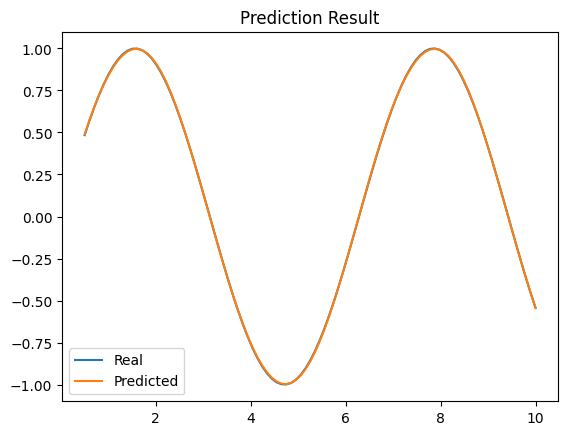

[2000/10000] loss = 4.44092484030989e-06


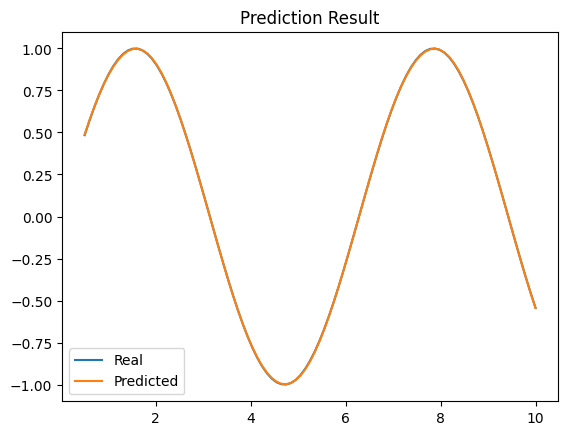

[3000/10000] loss = 2.450644615237252e-06


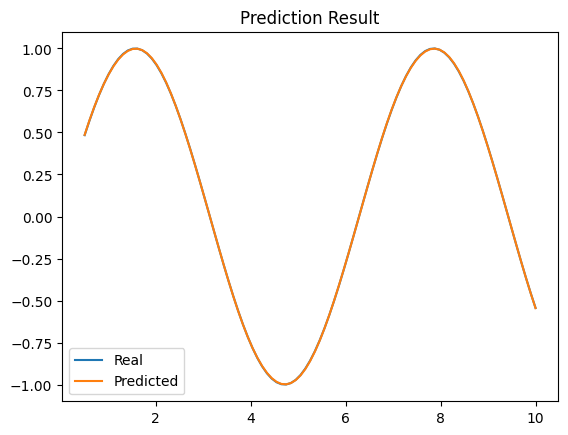

[4000/10000] loss = 1.8931151544165914e-06


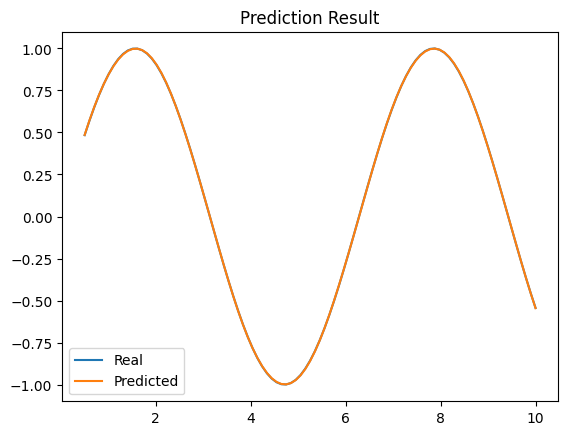

[5000/10000] loss = 1.6844021502038231e-06


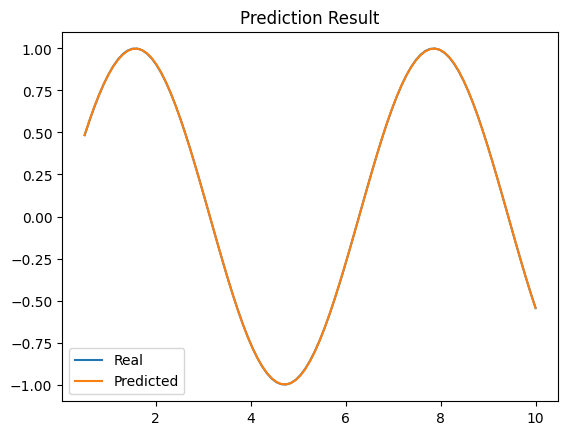

[6000/10000] loss = 1.566795731378079e-06


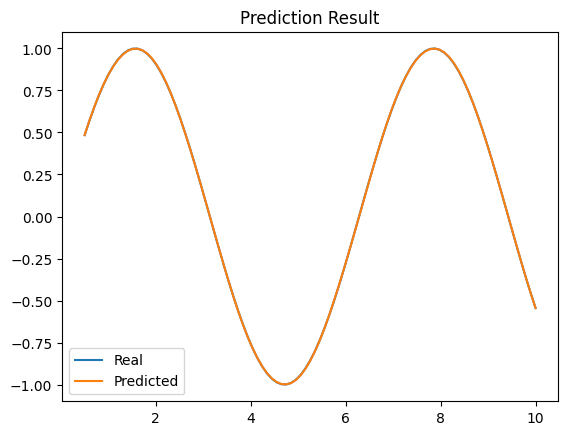

[7000/10000] loss = 1.4778944432691787e-06


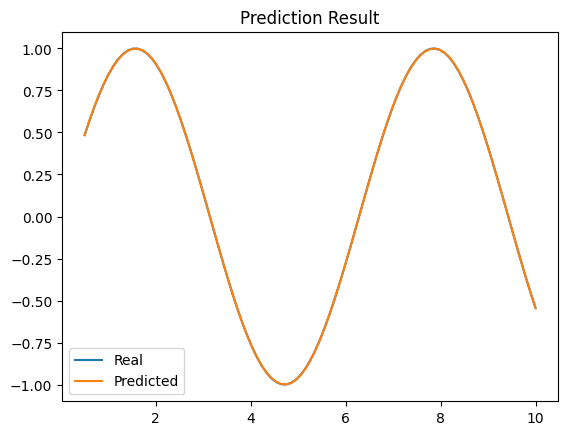

[8000/10000] loss = 1.4016957265994279e-06


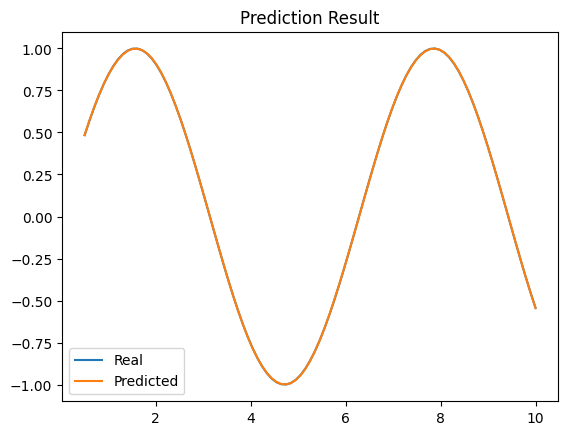

[9000/10000] loss = 1.333538079961727e-06


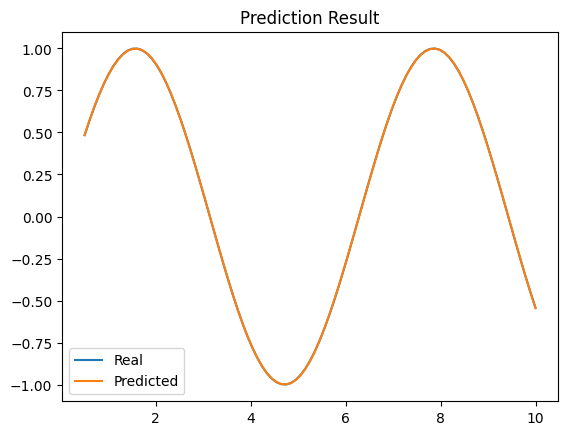

[10000/10000] loss = 1.2716799346890184e-06


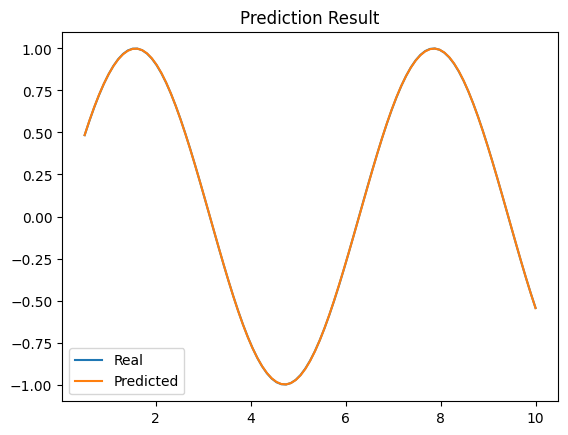

In [16]:
rnn1 = RNN1(input_dim, output_dim, hidden_dim).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(rnn1.parameters(), lr=0.005, momentum=0.9)

print("[ Training Start ]")
show(rnn1)

epoch = 10000

for i in range(epoch):
    rnn1.train()
    rnn1.zero_grad()
    optimizer.zero_grad()

    h = torch.zeros(train_size, hidden_dim).to(device)

    # 시퀀스에 포함된 데이터를 연속적으로 넣기
    # 여기가 핵심(지금 재귀적으로 동작하고 있음)
    # train_X.shape = (5, 95 ,1)
    # 학습 데이터가 95개란 의미
    # 따라서, 학습 데이터맏 5번씩 "재귀적으로" 모델에 넣어주어야 결과 y가 나온다. (재귀 깊이: 5)
    for x in train_X: # train_X의 길이는 "5 (seq_len)"
        y_pred, h = rnn1(x, h)

    # 손실(loss) 값을 계산하여 학습 진행
    loss = loss_fn(train_Y, y_pred)
    loss.backward()
    optimizer.step()

    if not (i + 1) % 1000:
        print(f"[{i + 1}/{epoch}] loss = {loss.item()}")
        show(rnn1)

<b>평가 진행</b>
* 처음 5개만 주고 시작했을 때, 무한히 예측 가능한가?

In [17]:
# 평가를 위한 하나의 시퀀스 생성
test_X = train_X[:, 0, :].unsqueeze(2) # 첫 시퀀스만 사용했습니다!
print(test_X.shape)

rnn1.eval()
predictions = []

for i in range(1000):
    h = torch.zeros(1, hidden_dim).to(device)

    # 시퀀스에 포함된 데이터를 연속적으로 넣기
    for x in test_X:
        y_pred, h = rnn1(x, h)

    test_X = torch.cat((test_X, y_pred.unsqueeze(0)), dim=0)[1:] # test_X에 맞춰 0차원으로(행으로) y_pred를 확장하고, 0차원 방향으로 concat하겠다.
    predictions.append(y_pred.item())

torch.Size([5, 1, 1])


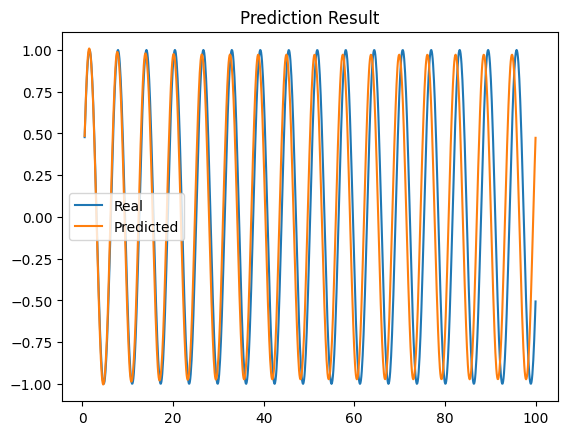

In [18]:
test_x = np.linspace(0, 100, 1000 + sequence_size)
test_y = np.sin(test_x) # 각 포인트에 대한 sine() 값 계산

plt.title("Prediction Result")
plt.plot(test_x[sequence_size:], test_y[sequence_size:])
plt.plot(test_x[sequence_size:], predictions)
plt.legend(["Real", "Predicted"])
plt.show()

In [19]:
rnn1

RNN1(
  (w_xh): Linear(in_features=1, out_features=1000, bias=True)
  (w_hh): Linear(in_features=1000, out_features=1000, bias=True)
  (w_hy): Linear(in_features=1000, out_features=1, bias=True)
)

<b>MLP로 예측하기</b>

[0.         0.06688963 0.13377926 0.2006689  0.26755853]
[0.         0.06683976 0.13338058 0.19932485 0.26437762]
(300,)
(300,)


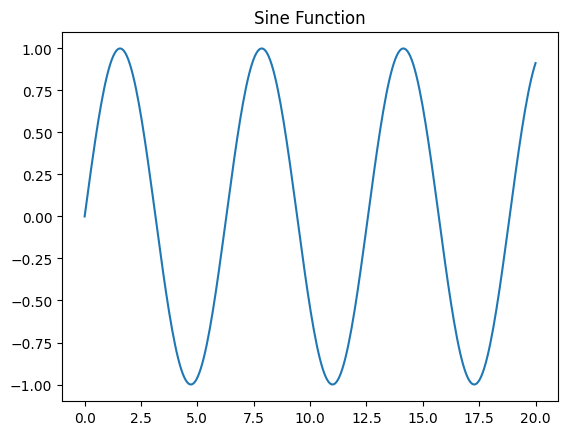

In [20]:
data_size = 300

data_x = np.linspace(0, 20, data_size)
data_y = np.sin(data_x)

print(data_x[:5])
print(data_y[:5])

print(data_x.shape)
print(data_y.shape)

plt.title("Sine Function")
plt.plot(data_x, data_y)
plt.show()

In [21]:
train_X_mlp = []
train_Y_mlp = []

for i in range(data_size):
    train_X_mlp.append(data_x[i]) # 현재의 x가 주어졌을 때
    train_Y_mlp.append(data_y[i]) # 현재의 y를 예측

# 학습 데이터 100개는 아래와 같이 구성된다.
# (x1), (sin(x1))
# (x2), (sin(x2))
# (x3), (sin(x3))
# ...

train_X_mlp = np.array(train_X_mlp)
train_Y_mlp = np.array(train_Y_mlp)

# [시퀀스의 개수, 시퀀스 크기]
print(train_X_mlp.shape)
print(train_Y_mlp.shape)

train_X_mlp = torch.from_numpy(train_X_mlp).unsqueeze(1).float().to(device)
train_Y_mlp = torch.from_numpy(train_Y_mlp).unsqueeze(1).float().to(device)

print(train_X_mlp.shape)
print(train_Y_mlp.shape)

(300,)
(300,)
torch.Size([300, 1])
torch.Size([300, 1])


In [25]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.input_layer = nn.Linear(self.input_dim, self.hidden_dim)
        self.hidden_layer = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        """
        layer width = 5
        """
        x = self.input_layer(x)
        x = nn.ReLU()(x)

        x = self.hidden_layer(x)
        x = nn.ReLU()(x)
        x = self.hidden_layer(x)
        x = nn.ReLU()(x)
        x = self.hidden_layer(x)
        x = nn.ReLU()(x)
        x = self.hidden_layer(x)
        x = nn.ReLU()(x)
        x = self.hidden_layer(x)
        x = nn.ReLU()(x)

        x = self.output_layer(x)
        return x

In [26]:
# 현재 모델의 출력을 확인
def show_mlp(mlp):
    mlp.eval()
    predictions = []

    h = torch.zeros(train_size, hidden_dim).to(device)

    y_pred = mlp(train_X_mlp)

    plt.title("Prediction Result")
    plt.plot(data_x, data_y)
    plt.plot(data_x, y_pred.view(-1).cpu().detach().numpy())
    plt.legend(["Real", "Predicted"])
    plt.show()

[ Training Start ]


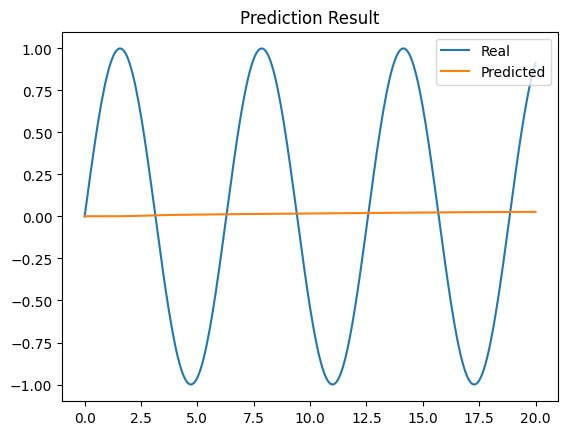

[1000/30000] loss = 0.47641196846961975


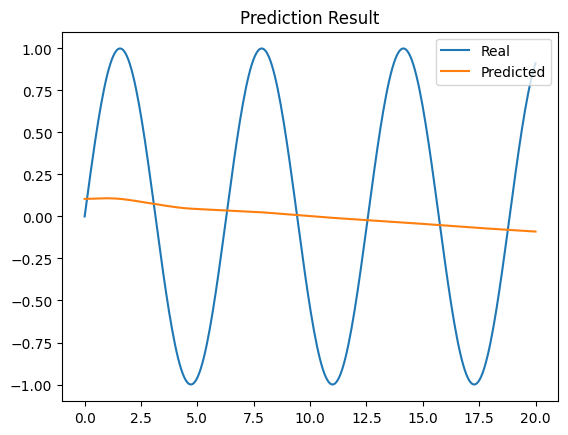

[2000/30000] loss = 0.47079798579216003


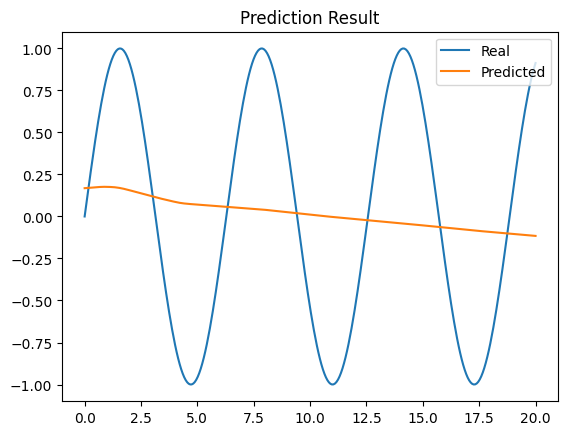

[3000/30000] loss = 0.46656566858291626


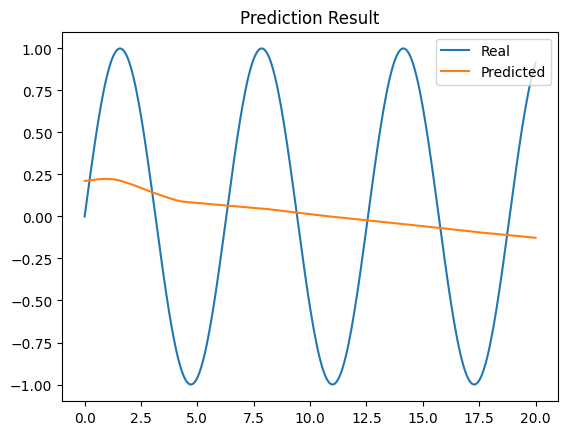

[4000/30000] loss = 0.4622190594673157


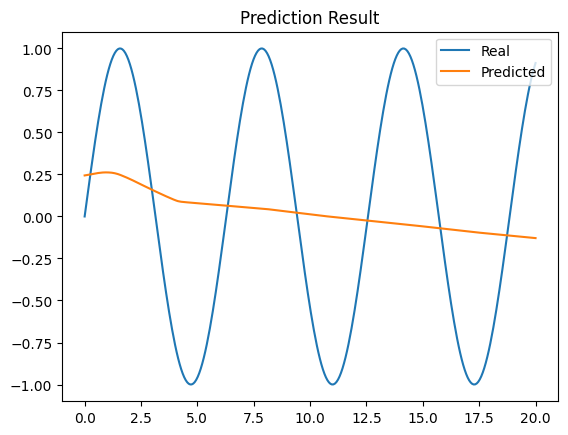

[5000/30000] loss = 0.4568943381309509


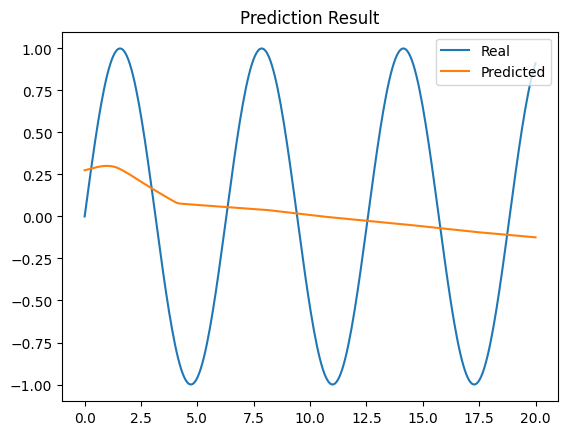

[6000/30000] loss = 0.44988781213760376


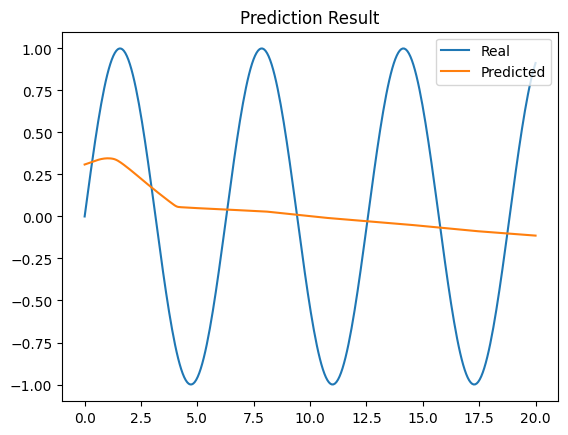

[7000/30000] loss = 0.44057705998420715


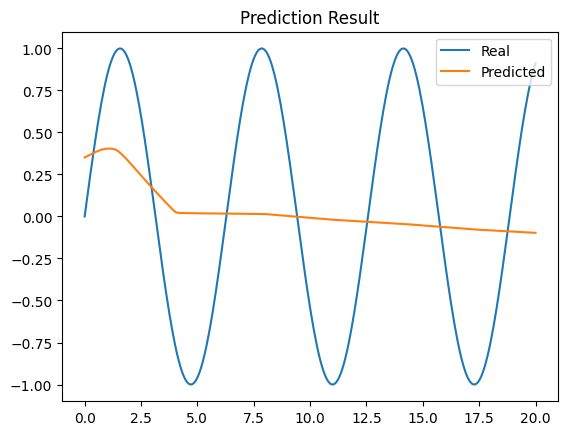

[8000/30000] loss = 0.42867758870124817


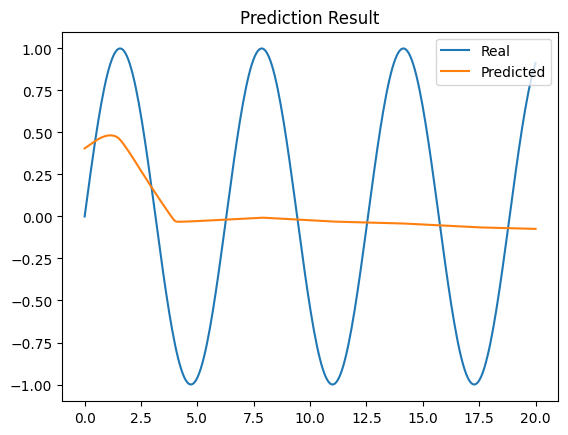

[9000/30000] loss = 0.4153977036476135


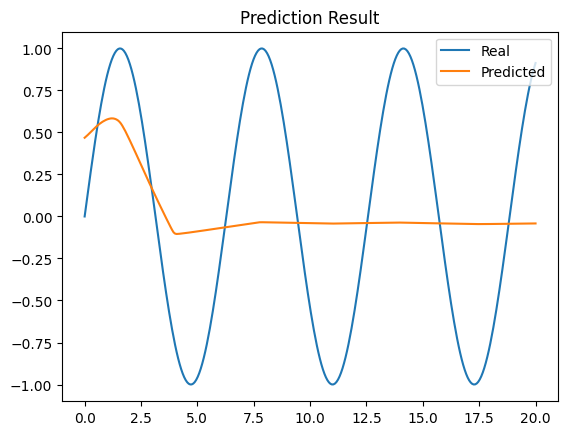

[10000/30000] loss = 0.402920126914978


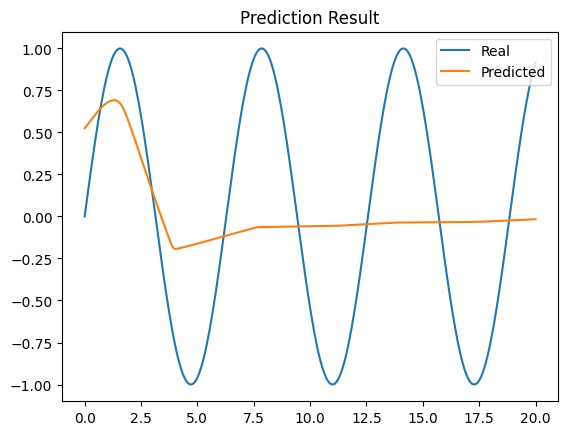

[11000/30000] loss = 0.3925124406814575


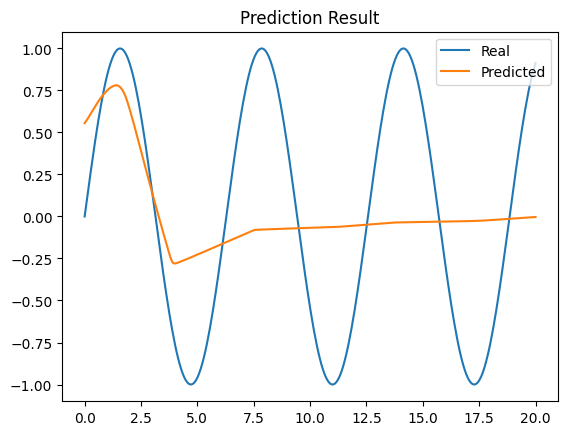

[12000/30000] loss = 0.3821428120136261


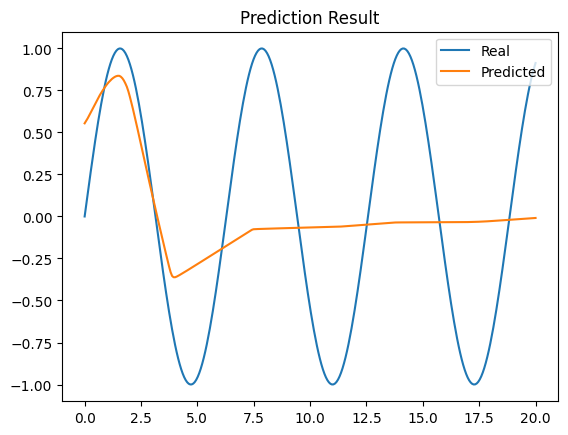

[13000/30000] loss = 0.36988401412963867


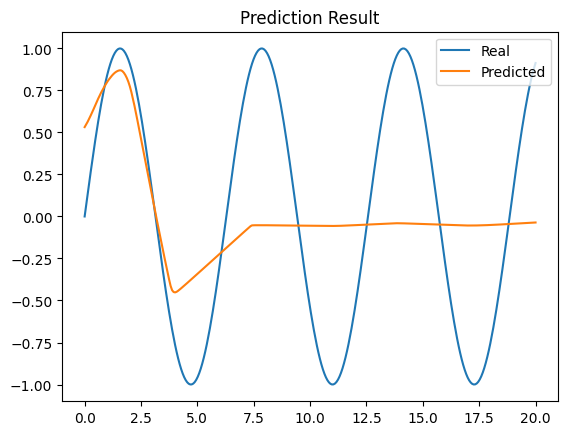

[14000/30000] loss = 0.3564182221889496


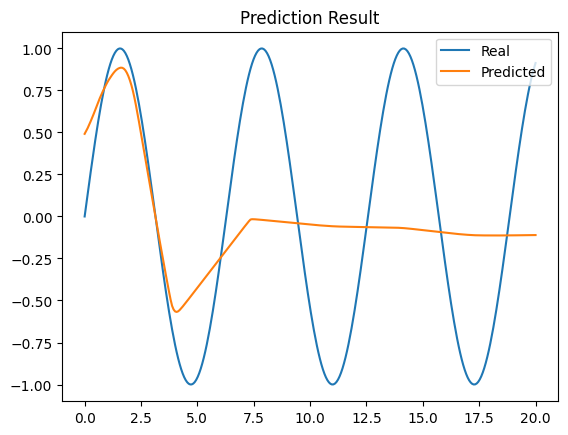

[15000/30000] loss = 0.34226515889167786


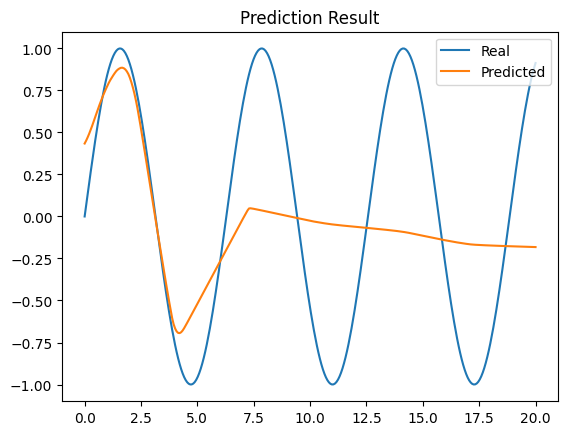

[16000/30000] loss = 0.3300968110561371


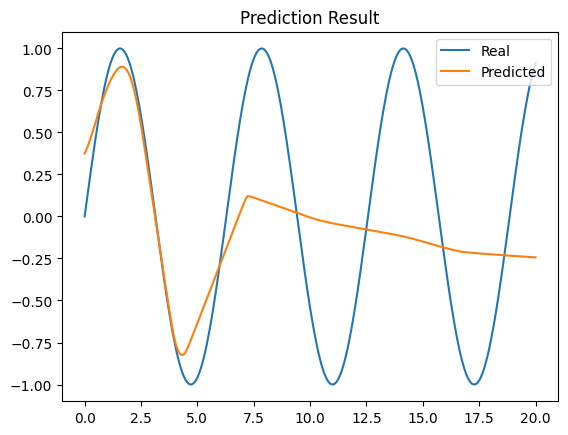

[17000/30000] loss = 0.3172367513179779


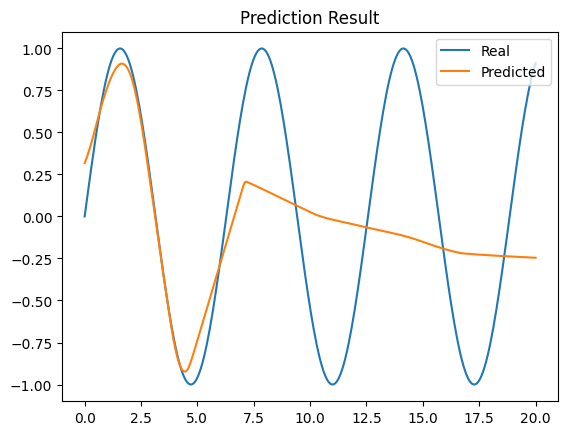

[18000/30000] loss = 0.30743277072906494


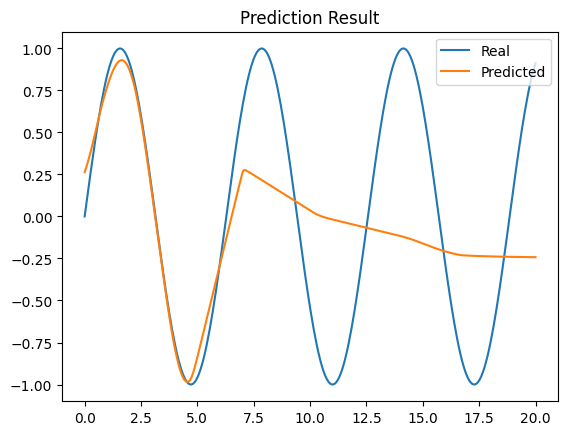

[19000/30000] loss = 0.29602742195129395


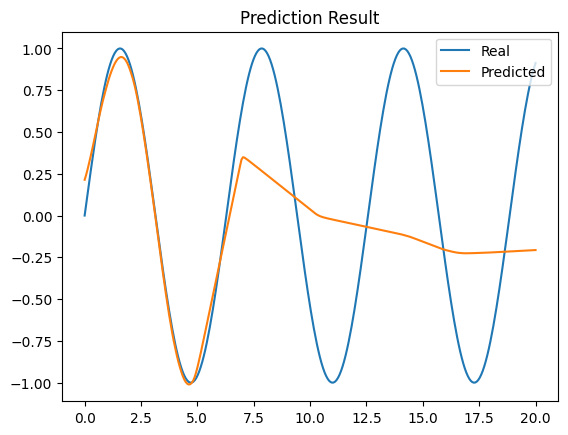

[20000/30000] loss = 0.2809964716434479


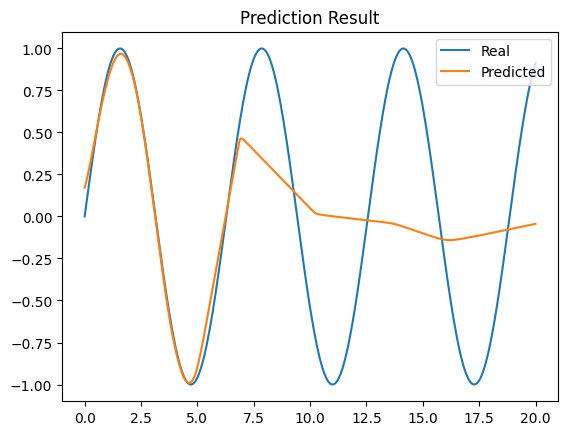

[21000/30000] loss = 0.2791791558265686


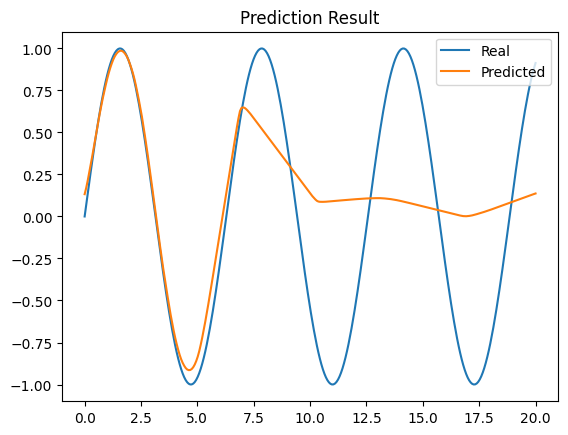

[22000/30000] loss = 0.26593855023384094


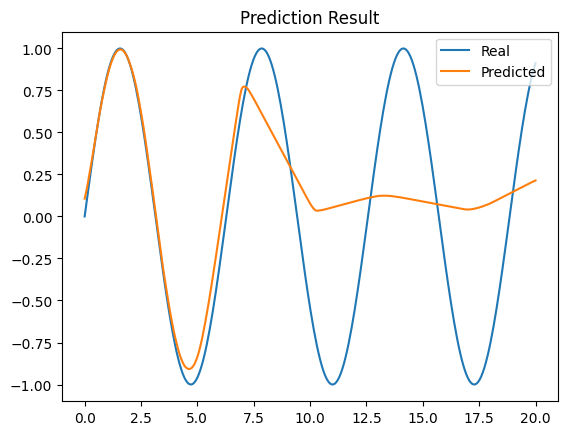

[23000/30000] loss = 0.24105305969715118


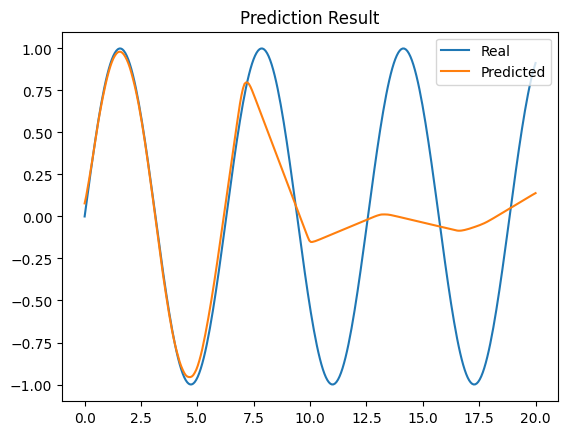

[24000/30000] loss = 0.23153696954250336


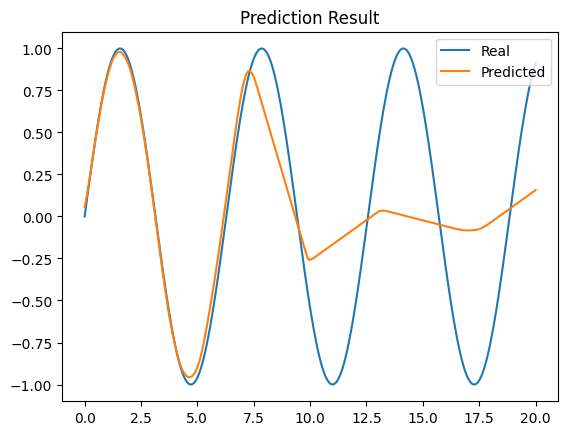

[25000/30000] loss = 0.2570831775665283


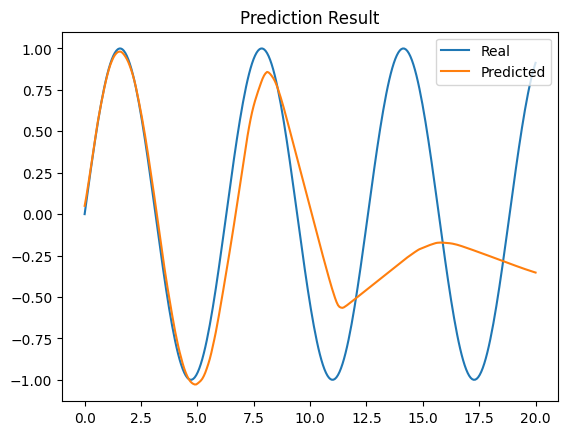

[26000/30000] loss = 0.21528485417366028


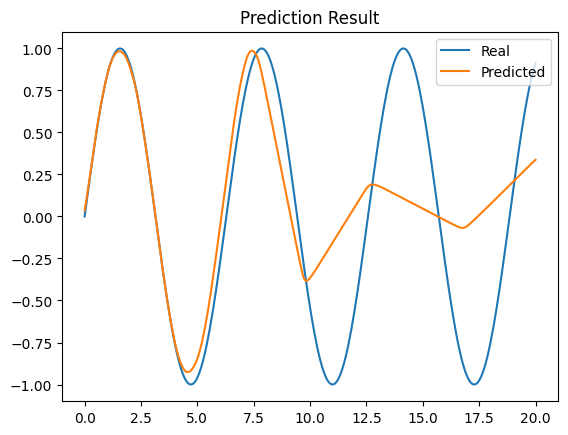

[27000/30000] loss = 0.20707851648330688


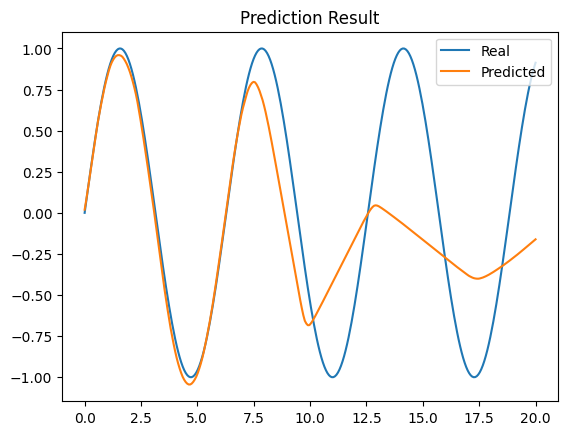

[28000/30000] loss = 0.24478314816951752


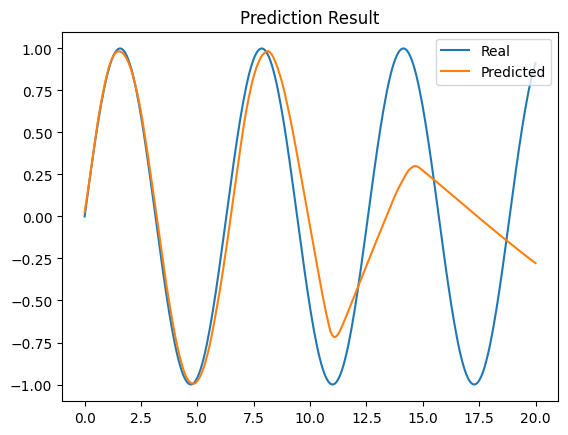

[29000/30000] loss = 0.1407691240310669


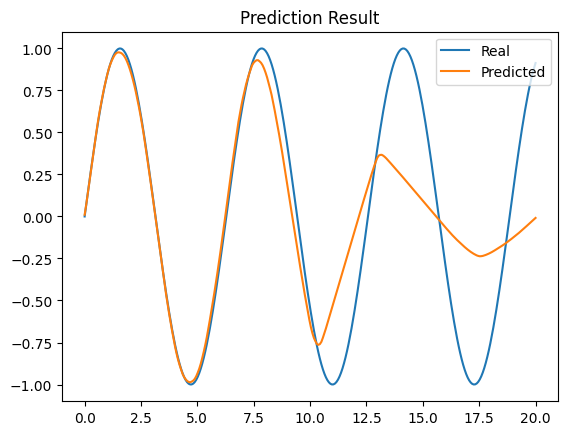

[30000/30000] loss = 0.13326996564865112


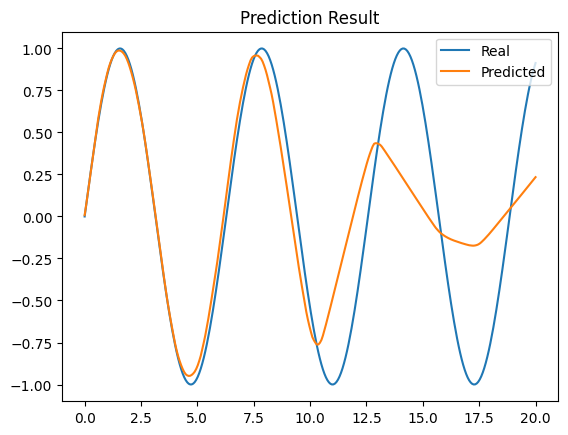

In [27]:
mlp = MLP(input_dim, output_dim, 1000).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001)

print("[ Training Start ]")
show_mlp(mlp)

epoch = 30000

for i in range(epoch):
    mlp.train()
    mlp.zero_grad()
    optimizer.zero_grad()

    h = torch.zeros(train_size, hidden_dim).to(device)

    y_pred = mlp(train_X_mlp)

    # 손실(loss) 값을 계산하여 학습 진행
    loss = loss_fn(train_Y_mlp, y_pred)
    loss.backward()
    optimizer.step()

    if not (i + 1) % 1000:
        print(f"[{i + 1}/{epoch}] loss = {loss.item()}")
        show_mlp(mlp)

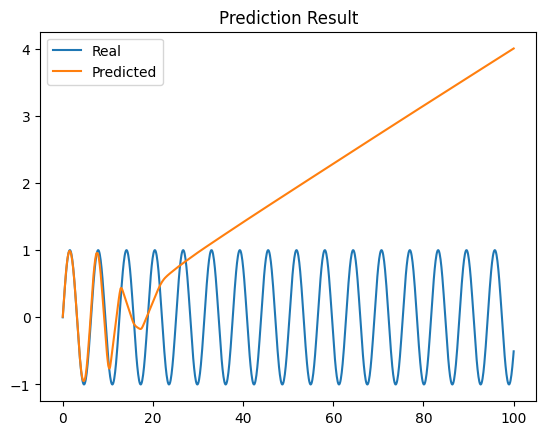

In [29]:
test_x = np.linspace(0, 100, 1000)
test_y = np.sin(test_x)
test_X = torch.from_numpy(test_x).to(device).unsqueeze(1).float()
y_pred = mlp(test_X)

plt.title("Prediction Result")
plt.plot(test_x, test_y)
plt.plot(test_x, y_pred.cpu().detach().numpy())
plt.legend(["Real", "Predicted"])
plt.show()

In [31]:
test_Y_mlp = np.array(test_y)
print(test_Y_mlp.shape)
test_Y_mlp = torch.from_numpy(test_Y_mlp).unsqueeze(1).float().to(device)
print(test_Y_mlp.shape)
loss = loss_fn(test_Y_mlp, y_pred)
print(loss)

(1000,)
torch.Size([1000, 1])
tensor(5.4629, device='cuda:0', grad_fn=<MseLossBackward0>)
